<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM (v4)
This notebook is the first step towards building up to a real SLAM model.
It focuses on proving out the model architecture, without going into too much w.r.t. proper data generation.

In [4]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout 63bcc74
!cd repo && git pull

import sys
sys.path.append('repo')

import lds
import map_from_lds_train_data
import slam
from importlib import reload
reload(lds)
reload(map_from_lds_train_data)
reload(slam)

HEAD is now at 41d234e Locked to revision
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 12 (delta 4), reused 12 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (12/12), 10.47 KiB | 255.00 KiB/s, done.
From https://github.com/malcolmlett/robovac
   41d234e..84e6a0c  main       -> origin/main
Updating 41d234e..84e6a0c
Fast-forward
 data/experimental-floorplan2.pdn                                | Bin 0 -> 11215 bytes
 data/experimental-floorplan2.png                                | Bin 0 -> 1851 bytes
 ..._2024-10-10-11-42-09-85_89ed83f5c7ca8fa2c91fc75c50289338.jpg | Bin 306693 -> 0 bytes
 ..._2024-10-10-11-42-45-65_89ed83f5c7ca8fa2c91fc75c50289338.jpg | Bin 341005 -> 0 bytes
 ..._2024-10-10-11-43-34-83_89ed83f5c7ca8fa2c91fc75c50289338.jpg | Bin 340516 -> 0 bytes
 ..._2024-10-10-11-45-03-20_89ed83f5c7ca8fa2c91fc75c50289338.jpg | Bin 340089 -> 0 bytes
 ..._2024-10-10-11-48-26-03_

<module 'slam' from '/content/repo/slam.py'>

In [2]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import cv2
import requests
import math
import ipdb
from timeit import default_timer as timer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.4 MB/s eta 0:00:00


## Helper functions


In [5]:
def display_history(history):
  plt.figure(figsize=(11,3))
  plt.subplot(1,2,1)
  plt.plot(model_history.history["loss"])
  plt.title("Loss")

  plt.subplot(1,2,2)
  plt.plot(model_history.history["accuracy"])
  plt.title("Accuracy")
  plt.show()

def show_prediction(display_list, titles):
    plt.figure(figsize=(10, 3))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.axis('off')
    plt.show()

def show_predictions(model, dataset, num=1, show_probs=True):
    """
    Displays the first image of each of the num batches
    """
    for image, ground_truth in dataset.take(num):
        batch = np.expand_dims(image, axis=0)
        batch_pred = model.predict(batch)
        pred = tf.argmax(batch_pred, axis=-1)[0]

        if show_probs:
          # showing full details
          print(f"Class 0 logit range - {tf.reduce_min(batch_pred[..., 0])}, {tf.reduce_max(batch_pred[..., 0])}")
          print(f"Class 1 logit range - {tf.reduce_min(batch_pred[..., 1])}, {tf.reduce_max(batch_pred[..., 1])}")
          #probs = tf.nn.softmax(batch_pred[0], axis=-1)
          probs = batch_pred[0]  # show the raw logits
          class0_prob = probs[:, :, 0]
          class1_prob = probs[:, :, 1]
          show_prediction(
              [image, ground_truth, pred, class0_prob, class1_prob],
              ['LDS Data', 'Ground Truth', 'Predicted', 'Class 0', 'Class 1'])
        else:
          show_prediction([image, ground_truth, pred], ['LDS Data', 'Ground Truth', 'Predicted'])

## Load Floorplan

In [32]:
def one_hot_encode_floorplan(image):
    """
    Converts an RGB floorplan image into a one-hot encoded tensor of the same form
    used as input and output maps in the SLAM model.

    Ordered channels are:
    - floor (white in the RGB image)
    - obstruction (black in the RGB image)
    - unknown (grey in the RGB image)

    Args:
      image: (H,W,3) RGB floorplan image

    Returns:
      (H,W,C) one-hot encoded tensor of the floorplan image
    """
    # sanity check
    if not np.array_equal(np.unique(image), np.array([0, 192, 255])):
      raise ValueError(f"Encountered unexpected values in image, expected [0, 192, 255], got: {np.unique(image)}")

    # get each channel
    floor_mask = tf.reduce_all(tf.equal(image, [255, 255, 255]), axis=-1)
    obstruction_mask = tf.reduce_all(tf.equal(image, [0, 0, 0]), axis=-1)
    unknown_mask = tf.reduce_all(tf.equal(image, [192, 192, 192]), axis=-1)

    # Stack the masks along the last dimension to create a one-hot encoded tensor
    one_hot_image = tf.stack([floor_mask, obstruction_mask, unknown_mask], axis=-1)

    return tf.cast(one_hot_image, tf.float32)

In [38]:
floorplan = Image.open('repo/data/experimental-floorplan2.png')
floorplan = np.array(floorplan, dtype=np.uint8)
print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

floorplan = one_hot_encode_floorplan(floorplan).numpy()
print(f"one-hot encoded: shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255
one-hot encoded: shape=(139, 294, 3), dtype=float32, value range: 0.0 - 1.0


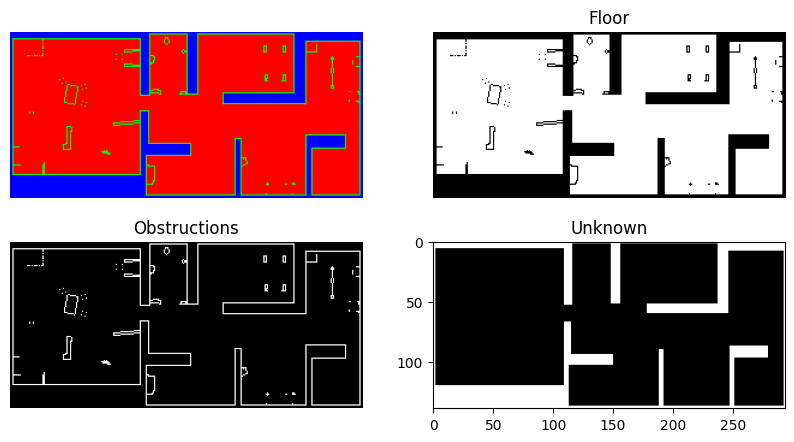

In [39]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(floorplan)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Floor')
plt.imshow(floorplan[:,:,0], cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Obstructions')
plt.imshow(floorplan[:,:,1], cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Unknown')
plt.imshow(floorplan[:,:,2], cmap='gray')
#plt.axis('off')

## Training data
Here we're going to need to generate new training data. The old training data is in the wrong data structure, uses the wrong encoding for our needs, and used a simple floorplan.

In [6]:
# If generated data is available then load that to save time:
loaded = np.load('repo/data/experimental-slam-training-data1.npz')
X = loaded['X']
Y = loaded['Y']
print(f"X: {len(X)} x {X[0].shape}")
print(f"Y: {len(Y)} x {Y[0].shape}")

# Make available for training
dataset = tf.data.Dataset.from_tensor_slices((X, Y))

X: 1000 x (105, 105)
Y: 1000 x (105, 105)


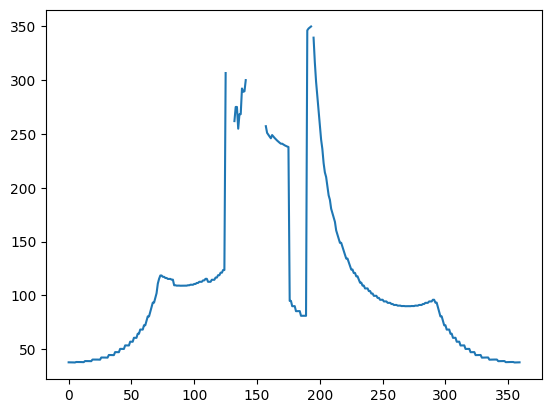

In [41]:
reload(map_from_lds_train_data)
np.random.seed(0)
pixel_size = 4.741
location = np.array([100, 100]) * pixel_size

ranges = lds.lds_sample(floorplan[:,:,1], location, 0.0, max_distance=350, pixel_size=pixel_size)

plt.plot(ranges)
plt.show()


window_size: [149 149], location: [100 101] + [ 0.2 -0.2] = [100.2 100.8]
map_window: (149, 149, 3)
ground_truth_map: (149, 149, 3)
pixel_size: 4.741, centre_px: [ 0.2 -0.2], map_centre_fpx: [74.2 73.8]
map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
centre offset:    [ 0.2 -0.2]


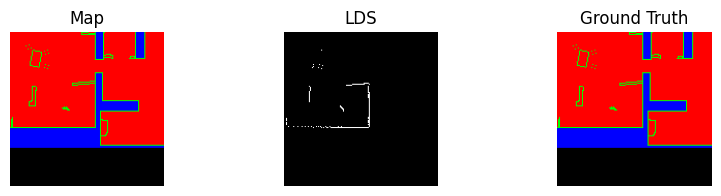

window_size: [149 149], location: [100 101] + [ 0.2 -0.2] = [100.2 100.8]
map_window: (149, 149, 3)
ground_truth_map: (149, 149, 3)
pixel_size: 4.741, centre_px: [ 0.2 -0.2], map_centre_fpx: [74.2 73.8]
map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
centre offset:    [ 0.2 -0.2]


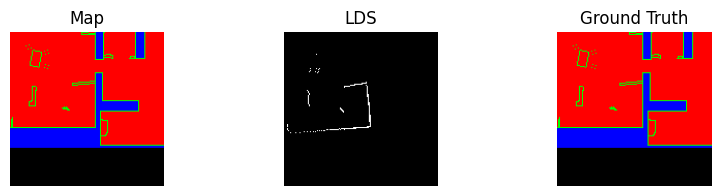

window_size: [149 149], location: [100 101] + [ 0.2 -0.2] = [100.2 100.8]
map_window: (149, 149, 3)
ground_truth_map: (149, 149, 3)
pixel_size: 4.741, centre_px: [ 0.2 -0.2], map_centre_fpx: [74.2 73.8]
map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
centre offset:    [ 0.2 -0.2]


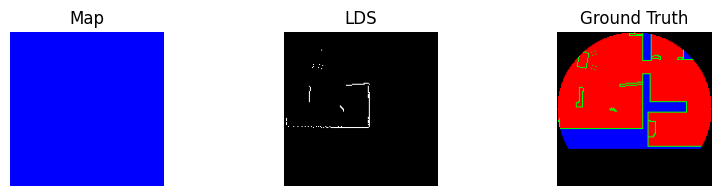

window_size: [149 149], location: [100 101] + [ 0.2 -0.2] = [100.2 100.8]
map_window: (149, 149, 3)
ground_truth_map: (149, 149, 3)
pixel_size: 4.741, centre_px: [ 0.2 -0.2], map_centre_fpx: [74.2 73.8]
map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
centre offset:    [ 0.2 -0.2]


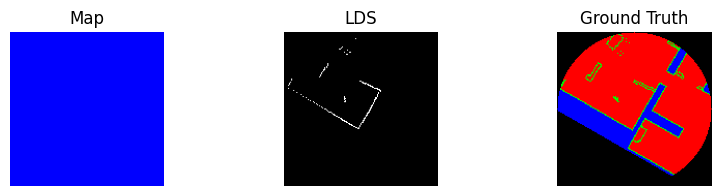

In [68]:
def generate_training_data_sample(semantic_map, location, orientation, map_known, believed_orientation, **kwargs):
    """
    :param semantic_map: (H,W,C) = one-hot encoded floorplan
    :param location: (float, float) = (x,y) actual location of agent
    :param orientation: (float) = radians actual angle of orientation of agent
    :param map_known: bool, whether to simulate the agent knowing this section of map or having a blank input map
    :param believed_orientation: float or None = radians, agent's belief of its orientation or None if unknown
    :param kwargs:
    :return:
      (input_map, input_lds_image, ground_truth_output_map, ground_truth_output_adlo)
    """
    # config
    max_distance = kwargs.get('max_distance', 100)
    pixel_size = kwargs.get('pixel_size', 1.0)
    #nothing_value = kwargs.get('nothing_value', np.array([1,0,0]))
    #occupied_value = kwargs.get('occupied_value', np.array([0,1,0]))
    #unknown_value = kwargs.get('occupied_value', np.array([0,0,1]))
    window_size_px = np.ceil(max_distance / pixel_size).astype(int) * 2 + 1
    window_size_px = np.array([window_size_px, window_size_px])
    n_channels = semantic_map.shape[-1]

    # take sample
    ranges = lds.lds_sample(semantic_map[:,:,1], location, orientation, max_distance=max_distance, pixel_size=pixel_size)
    if (np.nanmax(ranges) < pixel_size) or ranges[~np.isnan(ranges)].size == 0:
        return None, None, None, None

    # generate input map
    # (aligned to map pixels, and zero rotation)
    location_fpx = location / pixel_size  # sub-pixel resolution ("float pixels")
    location_px = np.round(location_fpx).astype(int)
    location_alignment_offset_fpx = location_fpx - location_px  # true centre relative to window centre
    print(f"window_size: {window_size_px}, location: {location_px} + {location_alignment_offset_fpx} = {location_fpx}")
    if map_known:
      map_window = map_from_lds_train_data.rotated_crop(semantic_map, location_px, 0.0, size=window_size_px, mask='none')
    else:
      # all unknown
      map_window = np.zeros((window_size_px[0], window_size_px[1], n_channels), dtype=semantic_map.dtype)
      map_window[:,:,2] = 1.0
    print(f"map_window: {map_window.shape}")

    # generate ground-truth map
    # (map_known:  aligned to map pixels and zero rotation)
    # (!may_known: aligned to exact centre of window and agent orientation)
    if map_known:
      ground_truth_map = map_from_lds_train_data.rotated_crop(semantic_map, location_px, 0.0, size=window_size_px, mask='none')
    else:
      ground_truth_map = map_from_lds_train_data.rotated_crop(semantic_map, location_fpx, orientation, size=window_size_px, mask='inner-circle')
    print(f"ground_truth_map: {ground_truth_map.shape}")

    # generate LDS semantic map
    # (note: from LDS data alone we don't know absolute centre or orientation, so we work relative to origin here)
    # (note: size_px is odd numbered, with equivalent of max_distance out from centre pixel)
    lds_orientation = believed_orientation if believed_orientation is not None else 0.0
    lds_map = lds_to_occupancy_map(ranges, start_angle=lds_orientation, size_px=window_size_px, centre_px=location_alignment_offset_fpx, pixel_size=pixel_size)

    return map_window, lds_map, ground_truth_map, location_alignment_offset_fpx

def lds_to_occupancy_map(ranges, start_angle, size_px, **kwargs):
    """
    :param ranges: array (n,) - range values may contain nans, which are dropped
    :param start_angle: angle of first range (radians)
    :param centre_px: array (2,) = float, [x,y] - centre point for ranges
    :param size_px: int/float or tuple (h, w) = size of output map in pixels
    :param kwargs

    Keyword args:
      pixel_size:
      centre_px: tuple, float (x,y), relative to map centre (unit: pixels)
        Usually centres LDS data exactly on centre of generated map (to sub-pixel resolution).
        Use this to shift by some amount.
      encoding: one of 'nn', 'antialiased', 'nn+offset':
        nn: nearest neighbour
        (TODO) antialised: blurs into adjacent pixels for implied sub-pixel resolution
        (TODO) nn+offset: picks single NN pixel, but on second and third channels adds
          x and y offset (-0.5 .. +0.5) in sub-pixel resolution

    :return: array (h,w) of floats in range [0,1]
    """

    # config
    pixel_size = kwargs.get('pixel_size', 1.0)
    centre_px = kwargs.get('centre_px', (0.0, 0.0))
    size_px = np.array(size_px) if len(size_px) == 2 else np.array([size_px, size_px])

    map_centre_fpx = np.array((size_px-1) / 2) + np.array(centre_px)

    print(f"pixel_size: {pixel_size}, centre_px: {centre_px}, map_centre_fpx: {map_centre_fpx}")

    lds_points = lds.lds_to_2d(ranges, (0, 0), start_angle)
    lds_points_px = np.round(lds_points/pixel_size + map_centre_fpx).astype(int)
    lds_map = np.full(size_px, 0.0, dtype=np.float32)
    lds_map[lds_points_px[:,1], lds_points_px[:,0]] = 1.0

    return lds_map

def display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset):
  print(f"map_window:       {map_window.shape}")
  print(f"lds_map:          {lds_map.shape}")
  print(f"ground_truth_map: {ground_truth_map.shape}")
  print(f"centre offset:    {centre_offset}")

  plt.figure(figsize=(10, 2))

  plt.subplot(1, 3, 1)
  plt.title('Map')
  plt.imshow(map_window)
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.title('LDS')
  plt.imshow(lds_map, cmap='gray')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.title('Ground Truth')
  plt.imshow(ground_truth_map, cmap='gray')
  plt.axis('off')
  plt.show()


reload(map_from_lds_train_data)
pixel_size = 4.741
location = np.array([100.2, 100.8]) * pixel_size
window_size = np.ceil(350 / pixel_size).astype(int) * 2 + 1

#ranges = lds.lds_sample(floorplan[:,:,1], location, 0.0, max_distance=350, pixel_size=pixel_size)
#map = lds_to_occupancy_map(ranges, start_angle=0.0, size_px=window_size, centre_px=(0.0, 0.0), pixel_size=pixel_size)

map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, location, 0.0, True, 0.0, pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, location, np.deg2rad(30.0), True, np.deg2rad(35.0), pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, location, 0.0, False, 0.0, pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, location, np.deg2rad(30.0), False, 0.0, pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

In [ ]:
# show first 5
plt.figure(figsize=(4, 10))
for i in range(0,5):
  plt.subplot(5,2,i*2+1)
  plt.imshow(X[i], cmap='gray')
  plt.axis('off')

  plt.subplot(5,2,i*2+2)
  plt.imshow(Y[i], cmap='gray')
  plt.axis('off')
plt.show()

# Save for later re-loading
# (needs to be manually downloaded and saved to repo)
#np.savez_compressed('experimental-slam-training-data1.npz', X=X, Y=Y)

## Model training

In [19]:
reload(slam)
data_shape = next(iter(dataset))[0].shape
input_size = (data_shape[0], data_shape[1], 1)

model = slam.slam_model(input_size, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 20
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(train_dataset, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
show_predictions(model, dataset, 5)

Map shape: (105, 105, 1) + padding (7, 7, 0)
Skip-connection merge mode: concat
Output: logits
Added final cropping layer: w=7, h=7
Epoch 1/20


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 112, 112, 1), found shape=(None, 105, 105)

In [10]:
tf.size((1, 2, 3)).numpy() == 3

True

In [12]:
np.size((1, 2, 3))

3